Cluster 1:
  Number of points: 45
  Coefficients:
    Feature 1: 2.6003
    Feature 2: -0.0013
    Feature 3: 0.1288
    Feature 4: 0.6274
    Feature 5: -24.6945
    Feature 6: 8.8877
    Feature 7: -0.0432
    Feature 8: -0.9965
    Feature 9: -0.1497
    Feature 10: -0.0370
    Feature 11: -1.3034
    Feature 12: 0.0184
    Feature 13: -0.3286
  Intercept: 15.29

Cluster 2:
  Number of points: 44
  Coefficients:
    Feature 1: 0.0000
    Feature 2: 0.0000
    Feature 3: 0.0000
    Feature 4: 0.0000
    Feature 5: 0.0000
    Feature 6: 0.0000
    Feature 7: 0.0000
    Feature 8: 0.0000
    Feature 9: 0.0000
    Feature 10: 0.0000
    Feature 11: 0.0000
    Feature 12: 0.0000
    Feature 13: 0.0000
  Intercept: 8.80

Cluster 3:
  Number of points: 305
  Coefficients:
    Feature 1: -0.1151
    Feature 2: 0.0440
    Feature 3: 0.0955
    Feature 4: 6.7931
    Feature 5: -19.5226
    Feature 6: -0.3383
    Feature 7: -0.0128
    Feature 8: -1.2069
    Feature 9: 0.2457
    Feature 10: -

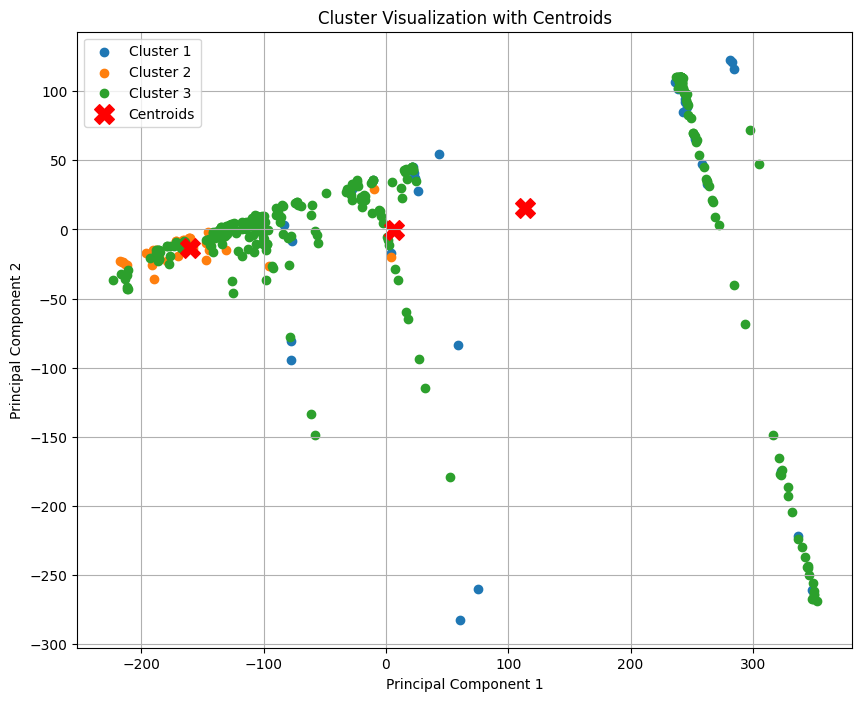

In [1]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.cluster import KMeans
from sklearn.metrics import mean_squared_error

# Step 1: Load Dataset (Example Dataset)
def load_data(filepath):
    """Load and preprocess the dataset."""
    data = pd.read_csv(filepath)
    data = data.dropna()  # Remove rows with NaN values
    X = data.iloc[:, :-1].values
    y = data.iloc[:, -1].values
    return X, y

# Step 2: Weighted Distance Calculation
def weighted_distance(x, g, W):
    """Calculate weighted distance using weight matrix W."""
    return np.sqrt((x - g).T @ W @ (x - g))

# Step 3: Adaptive Weight Matrix Calculation
def adaptive_quadratic_form(X, clusters, K, regularization=1e-6):
    """Compute adaptive weight matrices for each cluster."""
    weights = []
    for k in range(K):
        cluster_points = X[clusters == k]
        if len(cluster_points) > 1:  # Avoid singular matrix error
            cov_matrix = np.cov(cluster_points, rowvar=False)
            cov_matrix += regularization * np.eye(cov_matrix.shape[0])  # Add regularization
        else:
            cov_matrix = np.identity(cluster_points.shape[1])
        W = np.linalg.inv(cov_matrix)
        weights.append(W)
    return weights

# Step 4: Clusterwise Linear Regression Algorithm
def clusterwise_linear_regression(X, y, K, max_iter=100, stopping_threshold=1e-4):
    """Perform Clusterwise Linear Regression."""
    n, p = X.shape

    # Step 4a: Initialize clusters
    clusters = KMeans(n_clusters=K, random_state=42).fit_predict(X)
    weights = adaptive_quadratic_form(X, clusters, K)
    models = [LinearRegression() for _ in range(K)]

    for iteration in range(max_iter):
        #print(f"Iteration {iteration + 1}/{max_iter}")

        # Step 4c: Modeling Step
        for k in range(K):
            cluster_points = X[clusters == k]
            cluster_targets = y[clusters == k]
            if len(cluster_points) > 0:
                models[k].fit(cluster_points, cluster_targets)

        # Step 4d: Assignment Step
        new_clusters = np.zeros(n)
        for i in range(n):
            distances = [
                weighted_distance(X[i], models[k].predict(X[i].reshape(1, -1)), weights[k])
                for k in range(K)
            ]
            new_clusters[i] = np.argmin(distances)

        # Check stopping criteria
        if np.array_equal(clusters, new_clusters):
            print("Convergence achieved.")
            break

        clusters = new_clusters
        weights = adaptive_quadratic_form(X, clusters, K)

    return models, clusters, weights

# Step 5: Print Cluster Results
def print_cluster_results(models, clusters):
    """Print details of the regression models for each cluster."""
    for k, model in enumerate(models):
        print(f"Cluster {k + 1}:")
        print(f"  Number of points: {np.sum(clusters == k)}")
        print(f"  Coefficients:")
        for i, coef in enumerate(model.coef_):
            print(f"    Feature {i + 1}: {coef:.4f}")
        print(f"  Intercept: {model.intercept_:.2f}\n")

# Step 6: Predict New Point
def predict_new_point(new_point, models, weights):
    """Predict the value and cluster for a new data point."""
    predictions = [model.predict(new_point.reshape(1, -1)) for model in models]
    predicted_cluster = np.argmin([
        weighted_distance(new_point, pred, weights[k]) for k, pred in enumerate(predictions)
    ])
    return predictions[predicted_cluster][0], predicted_cluster

# Example Usage
if __name__ == "__main__":
    # Load data (replace 'HousingData.csv' with your dataset path)
    X, y = load_data('HousingData.csv')

    # Set the number of clusters
    K = 3

    # Perform Clusterwise Linear Regression
    models, clusters, weights = clusterwise_linear_regression(X, y, K)

    # Print cluster results
    print_cluster_results(models, clusters)

    # Predict for a new point
    new_point = np.array([0.00632, 18.00, 2.31, 0, 0.538, 6.575, 65.2, 4.0900, 1, 296.0, 15.3, 396.90, 4.98])
    predicted_value, predicted_cluster = predict_new_point(new_point, models, weights)
    print(f"Predicted value for the new point: {predicted_value:.2f}")
    print(f"The new point is assigned to Cluster {predicted_cluster + 1}")

    import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

def plot_clusters_with_centroids(X, clusters, K):
    # Perform PCA for dimensionality reduction to 2D
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X)

    # Calculate centroids in PCA-transformed space
    centroids = np.zeros((K, 2))
    for k in range(K):
        cluster_points = X_pca[clusters == k]
        centroids[k] = cluster_points.mean(axis=0)

    # Plot each cluster
    plt.figure(figsize=(10, 8))
    for k in range(K):
        cluster_points = X_pca[clusters == k]
        plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f'Cluster {k + 1}')

    # Plot centroids
    plt.scatter(centroids[:, 0], centroids[:, 1], c='red', marker='X', s=200, label='Centroids')

    # Add labels and legend
    plt.title('Cluster Visualization with Centroids')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.legend()
    plt.grid(True)
    plt.show()

# Plot the clusters with centroids
plot_clusters_with_centroids(X, clusters, K)